Import the needed packages and ml modules 

In [5]:
import numpy as np
import pandas as pd

import xarray as xr
import os
import sys

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from  torch.utils.data import TensorDataset
from torchsummary import summary
from sklearn.model_selection import KFold
import torch.nn.functional as F
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import folium
import folium.plugins
import pandas as pd
import xarray as xr
import branca
import branca.colormap as cm

Read offshore and onshore data

In [6]:
import sys

# Replace 'path_to_directory' with the actual path of the directory containing your Python file
sys.path.append('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/scripts/experiments')

import experiment as exp


In [7]:
try:
    MLDir = os.getenv('MLDir')
    SimDir = os.getenv('SimDir')
    reg = 'SR'
    train_size = '300'
    test_size = '1'
    mode = 'test'
    mask_size = '2400'
except:
    raise Exception("*** Must first set variable")

# load test events related parameters
event_list_path = f'{MLDir}/data/events/shuffled_events_test_{reg}_{test_size}.txt'
event_list = np.loadtxt(event_list_path, dtype='str')
n_eve = len(event_list)    

flood_mask = ~np.load(f'{MLDir}/data/processed/zero_mask_{reg}_{mask_size}.npy')
nflood_grids = np.count_nonzero(flood_mask)

# Define the model region related size/architecture
if reg == 'SR':
   GaugeNo = list(range(53,58)) #rough pick for Siracusa
   x_dim = 1300  #lon
   y_dim = 948 #lat
   ts_dim = len(GaugeNo) #no of gauges time series
   reg_gaugeno = str(54)
   control_points = [[37.01,15.29],
      [37.06757,15.28709],
      [37.05266,15.26536],
      [37.03211,15.28632]]
elif reg == 'CT':
   GaugeNo = list(range(35,44)) #for Catania
   x_dim = 912
   y_dim = 2224
   ts_dim = len(GaugeNo)
   reg_gaugeno = str(41)
   control_points =  [[37.5022,15.0960],
      [37.48876,15.08936],
      [37.47193,15.07816],
      [37.46273,15.08527],
      [37.46252,15.08587],
      [37.45312,15.07874],
      [37.42821,15.08506],
      [37.40958,15.08075],
      [37.38595,15.08539],
      [37.35084,15.08575],
      [37.33049,15.07029],]
   
pts = 480

# Load the model inputs for test events
t_array, red_d_array, red_dZ_array = exp.read_memmap(MLDir=MLDir,
                                                      reg=reg,
                                                      train_size=0,
                                                      test_size=test_size,
                                                      ts_dim=ts_dim,
                                                      pts_dim=pts,
                                                      n_eve = n_eve,
                                                      nflood_grids = nflood_grids,
                                                      what4 = mode,
                                                      normalize = False,
                                                      standardize = False)


reading memmap for test data size: 1


Autoencoder model for offshore to onshore time series

In [8]:
#build the offshore model
class Autoencoder_offshore(nn.Module):
    def __init__(self,
                 ninputs=5, #number of input channels or gauges
                 t_len = 480, #number of time steps
                 ch_list = [32,64,96], #number of channels in each layer
                 zdim = 50):#number of latent variables
        
        super(Autoencoder_offshore, self).__init__()
        # more channels mean more fine details, more resolution 
        # less channel and layers less likely to overfit so better maximas and minimas
        # more accuracy but slower and more memory and data needed to train
        self.ch_list = ch_list

        # define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv1d(ninputs, ch_list[0], kernel_size=3, padding=1),   
            nn.LeakyReLU(negative_slope=0.5,inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(ch_list[0], ch_list[1], kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.5,inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(ch_list[1], ch_list[2], kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.5,inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.1),
            nn.Flatten(),
            nn.Linear(int(t_len*ch_list[-1]/(2**len(ch_list))), zdim),          
        )

        # define decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(zdim,int(t_len*ch_list[-1]/(2**len(ch_list)))),
            nn.Unflatten(1, (ch_list[-1], int(t_len/(2**len(ch_list))))) ,
            nn.ConvTranspose1d(ch_list[2], ch_list[1], kernel_size=4, padding=1, stride= 2),  
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
            nn.ConvTranspose1d(ch_list[1], ch_list[0], kernel_size=4, padding=1, stride= 2), 
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
            nn.ConvTranspose1d(ch_list[0], ninputs, kernel_size=4, padding=1, stride= 2), 
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
        )

    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, x):
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        x = self.encode(x)  
        x = self.decode(x)
        return x

#build the onshore model
class Autoencoder_onshore(nn.Module):
    def __init__(self,
                 xy, #number of input channels or grids for flooding
                 zlist = [32,64,128]): #number of channels in each layer
        super(Autoencoder_onshore, self).__init__()
        # more channels mean more fine details, more resolution 
        # less channel and layers less likely to overfit so better maximas and minimas
        # more accuracy but slower and more memory and data needed to train
        self.xy = xy
        
        # define encoder layers
        if len(zlist) == 1:
            self.encoder = nn.Sequential(          
                nn.Linear(xy, zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
            self.decoder = nn.Sequential(
                nn.Linear(zlist[0], xy),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
        elif len(zlist) == 2:
            self.encoder = nn.Sequential(          
                nn.Linear(xy, zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[0], zlist[1]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
            self.decoder = nn.Sequential(
                nn.Linear(zlist[1], zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[0], xy),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
        elif len(zlist) == 3:
            self.encoder = nn.Sequential(          
                nn.Linear(xy, zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[0], zlist[1]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[1], zlist[2]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
            self.decoder = nn.Sequential(
                nn.Linear(zlist[2], zlist[1]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[1], zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[0], xy),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )

    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, x):
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        x = self.encode(x)  
        x = self.decode(x)
        return x

#build the coupled model
class Autoencoder_coupled(nn.Module):
    def __init__(self,
                offshore_model,
                onshore_model,
                deform_model,
                interface_layers,
                tune_layer):
        super(Autoencoder_coupled, self).__init__()

        # Pretrained offshore 
        self.offshore_encoder = offshore_model.encoder
        for i, layer in enumerate(self.offshore_encoder):
            if i < len(self.offshore_encoder) - tune_layer: #all layers except last
                for param in layer.parameters():
                    param.requires_grad = False
            else:
                for param in layer.parameters(): #last layer
                    param.requires_grad = True

        # Pretrained deform 
        self.deform_encoder = deform_model.encoder
        for i, layer in enumerate(self.deform_encoder):
            if i < len(self.deform_encoder) - tune_layer: #all layers except last
                for param in layer.parameters():
                    param.requires_grad = False
            else:
                for param in layer.parameters(): #last layer
                    param.requires_grad = True

        # Interface
        if interface_layers == 1:
            self.connect = nn.Sequential(
                                nn.Linear(
                                    in_features=64, out_features=64
                                ),
                                nn.ReLU(),
            ) 
        elif interface_layers == 2:    
            self.connect = nn.Sequential(
                                    nn.Linear(
                                        in_features=64, out_features=64
                                    ),
                                    nn.LeakyReLU(inplace=True),
                                    nn.Linear(
                                        in_features=64, out_features=64
                                    ),
                                    nn.LeakyReLU(inplace=True),
            )
        # Pretrained onshore model
        self.onshore_decoder = onshore_model.decoder 
        for i, layer in enumerate(self.onshore_decoder):
            if i < tune_layer:
                for param in layer.parameters(): #first layer
                    param.requires_grad = True
            else:
                for param in layer.parameters(): #all layers except first
                    param.requires_grad = False

    def forward(self, x, dz):
        x = self.offshore_encoder(x)
        # dz = self.deform_encoder(dz)
        # x = torch.cat((x, dz), dim=1)
        # x = self.connect(x)
        # x = torch.sub(x, dz)
        x = self.onshore_decoder(x)
        return x

In [9]:
exp.set_seed_settings(0)

z = 64
channels_off = [64,128,256]
channels_on = [64,64]
channels_deform = [64,64]

# couple_model = torch.load(f'{MLDir}/model/{reg}/out/model_couple_off{channels_off}_on{channels_on}_minepoch_{train_size}.pt', map_location=torch.device('cpu'))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 480]           1,024
         LeakyReLU-2              [-1, 64, 480]               0
         AvgPool1d-3              [-1, 64, 240]               0
            Conv1d-4             [-1, 128, 240]          24,704
         LeakyReLU-5             [-1, 128, 240]               0
         AvgPool1d-6             [-1, 128, 120]               0
            Conv1d-7             [-1, 256, 120]          98,560
         LeakyReLU-8             [-1, 256, 120]               0
         AvgPool1d-9              [-1, 256, 60]               0
          Dropout-10              [-1, 256, 60]               0
          Flatten-11                [-1, 15360]               0
           Linear-12                   [-1, 64]         983,104
           Linear-13                [-1, 15360]         998,400
        Unflatten-14              [-1, 

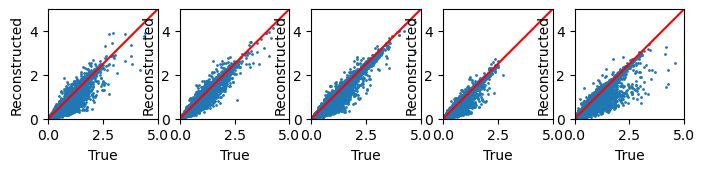

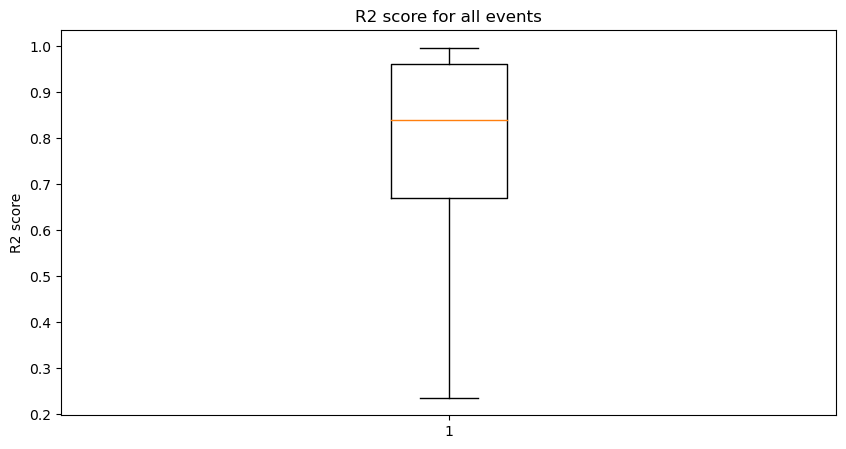

In [97]:
offshore_model = torch.load(f"{MLDir}/model/{reg}/out/model_offshore_ch_{channels_off}_minepoch_{train_size}.pt", map_location=torch.device('cpu'))

# Test model for final evaluation
#read model from file for testing
model = offshore_model
model.eval()
summary(model,(ts_dim,pts))
criterion = nn.MSELoss()
print(t_array.shape)
test_dataset = torch.tensor(t_array, dtype=torch.float32).to('cpu')
print(test_dataset.shape)
with torch.no_grad():
    recon_data = model(test_dataset)
tloss = criterion(recon_data, test_dataset)
print(f"Test loss: {tloss :.5f}", end="\r")

recon_data = recon_data[:, :, :].cpu().detach().numpy()

# Flatten the tables along the n_gauge and n_time axes to get 2D arrays (neve, n_gauge * n_time)
flat_table1 = test_dataset.reshape(test_dataset.shape[0],-1)
flat_table2 = recon_data.reshape(recon_data.shape[0],-1)

# Compute the R2 score for each event
flat_table1 = np.transpose(flat_table1)
flat_table2 = np.transpose(flat_table2)
r2_scores_off = r2_score(flat_table1, flat_table2, multioutput='raw_values')

#count events with score above 0.7
np.sum(r2_scores_off > 0.65)

#plot per gauge
plt.figure(figsize=(15, 3))
for g in range(5):
    plt.subplot(1, 9, g+1)
    plt.scatter(t_array[:, g, :].max(axis=1), recon_data[:, g, :].max(axis=1), s=1)
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    plt.xlabel('True')
    plt.ylabel('Reconstructed')
plt.show()

#plot r2 score as box plot
plt.figure(figsize=(10,5))
plt.boxplot(r2_scores_off,showfliers=False)
plt.title('R2 score for all events')
plt.ylabel('R2 score')
plt.show()

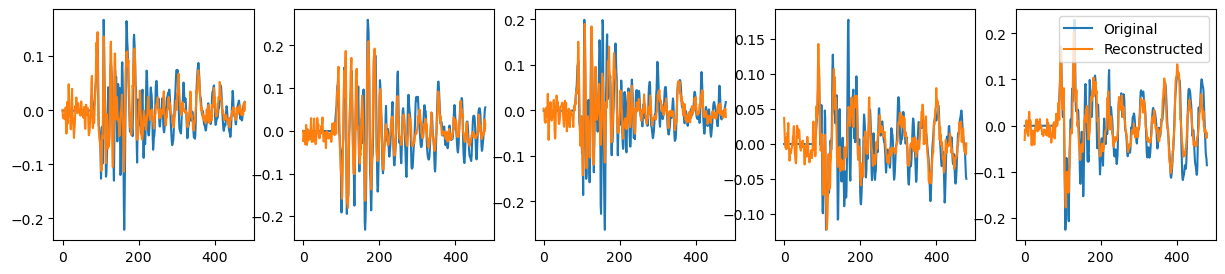

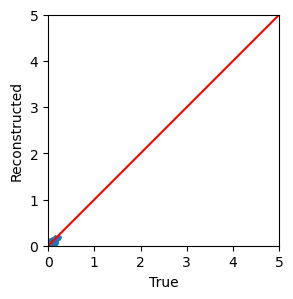

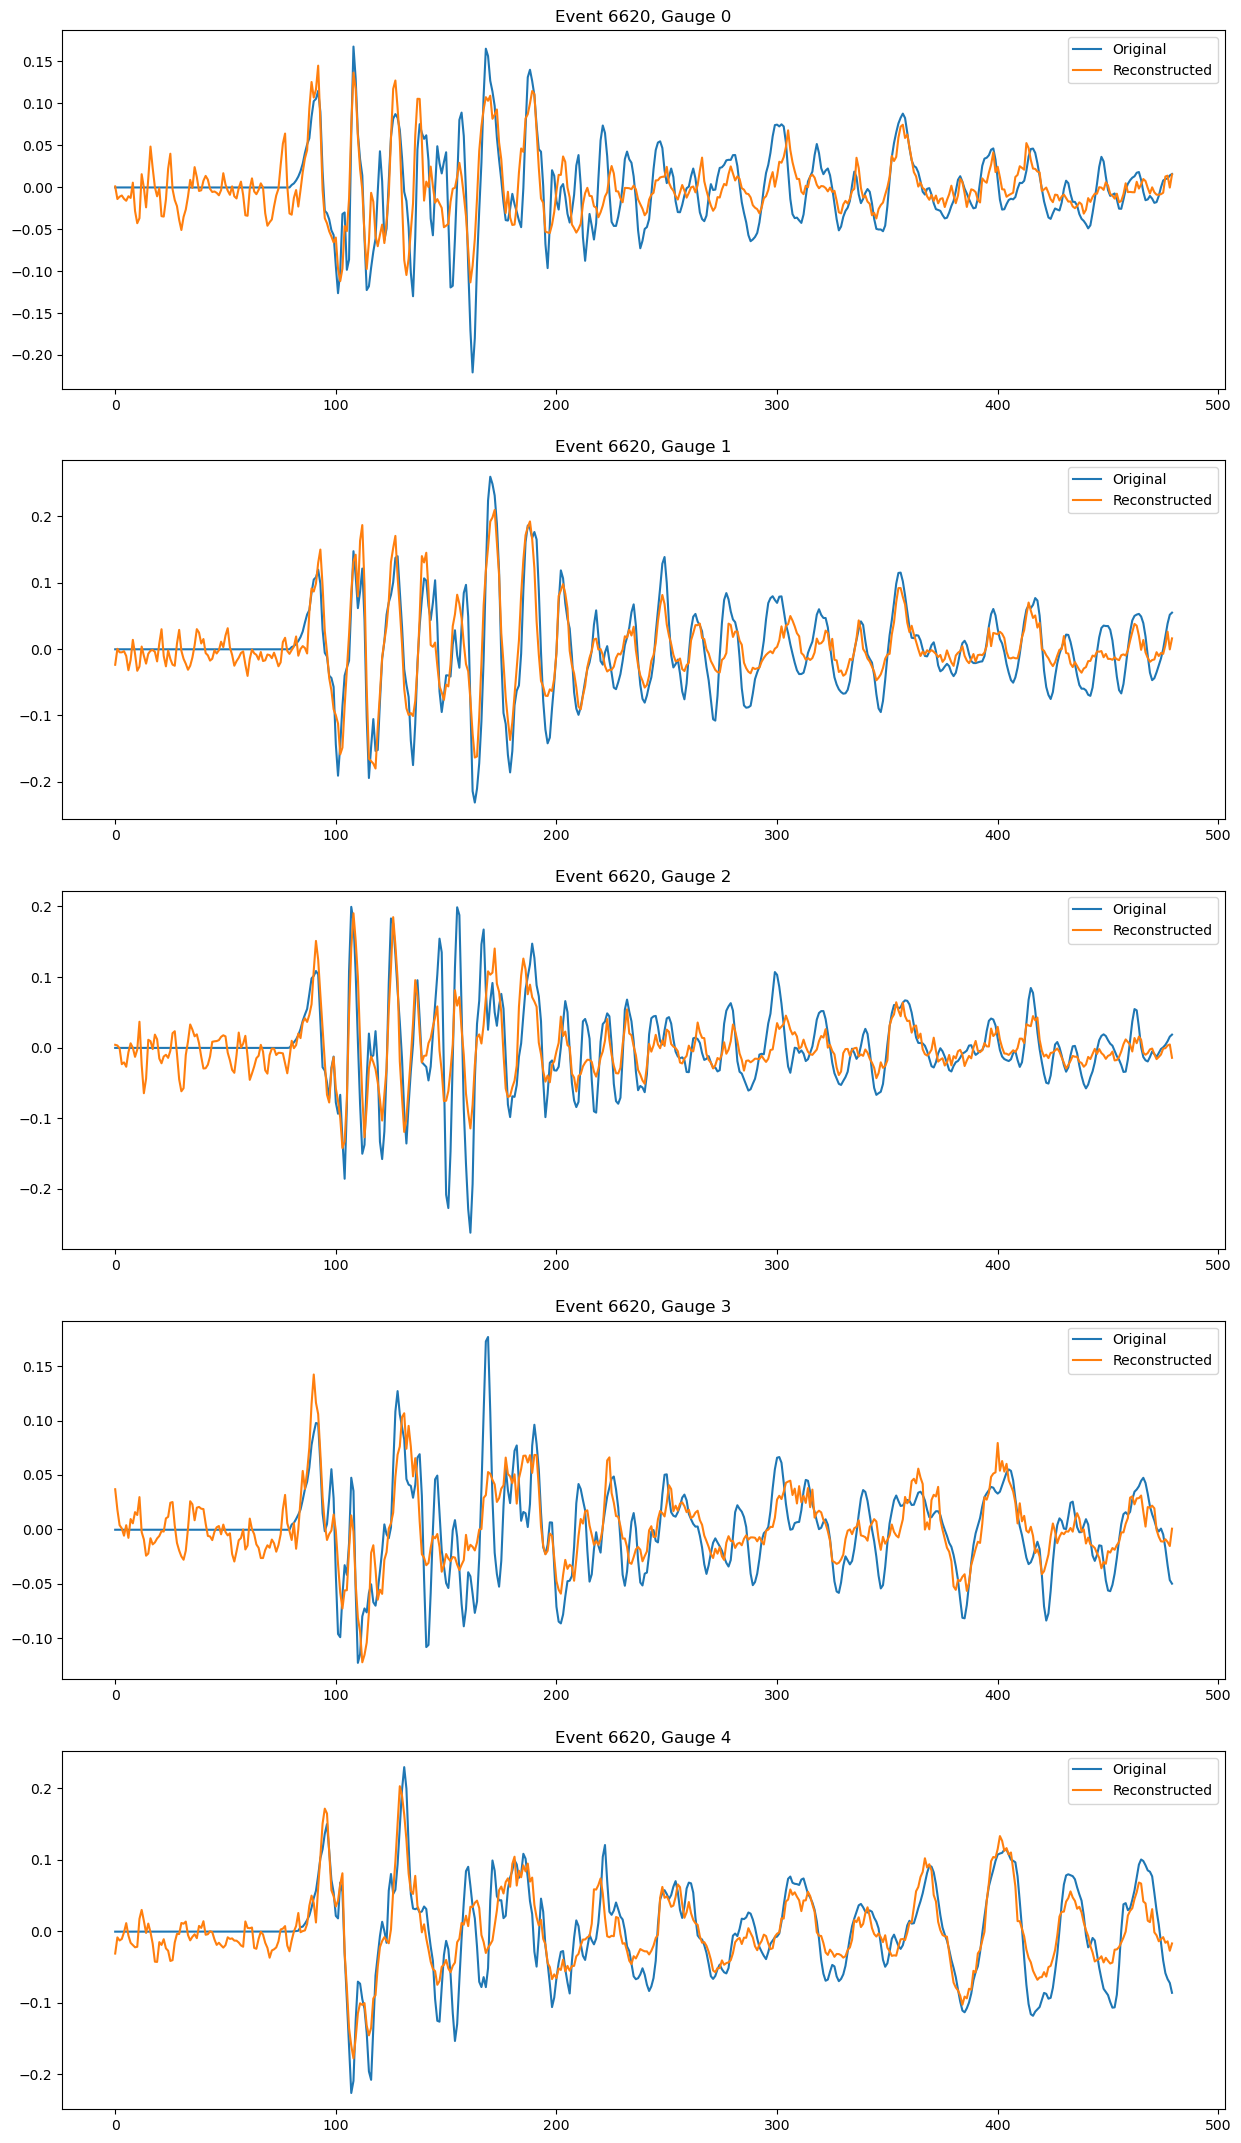

In [98]:
# Plot results all gauge
eve_no = 6620
plt.figure(figsize=(15, 3))
for g in range(5):
    plt.subplot(1, 5, g+1)
    plt.plot(t_array[eve_no, g, :], label="Original")
    plt.plot(recon_data[eve_no, g, :], label="Reconstructed")
plt.legend()
plt.show()

plt.figure(figsize=(15, 3))
plt.scatter(flat_table1[:,eve_no], flat_table2[:,eve_no], s=1)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

# Zoomed in
# Plot results for all gauges for one event row wise
plt.figure(figsize=(15, 27))
for g in range(5):
    plt.subplot(5, 1, g+1)
    plt.title(f"Event {eve_no}, Gauge {g}")
    plt.plot(t_array[eve_no, g, :], label="Original")
    plt.plot(recon_data[eve_no, g, :], label="Reconstructed")
    plt.legend()
plt.show()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]       5,822,656
         LeakyReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
         LeakyReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 64]           4,160
         LeakyReLU-6                   [-1, 64]               0
            Linear-7                [-1, 90978]       5,913,570
         LeakyReLU-8                [-1, 90978]               0
Total params: 11,744,546
Trainable params: 11,744,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.35
Forward/backward pass size (MB): 1.39
Params size (MB): 44.80
Estimated Total Size (MB): 46.54
----------------------------------------------------------------
(10175, 90978)


torch.Size([10175, 90978])


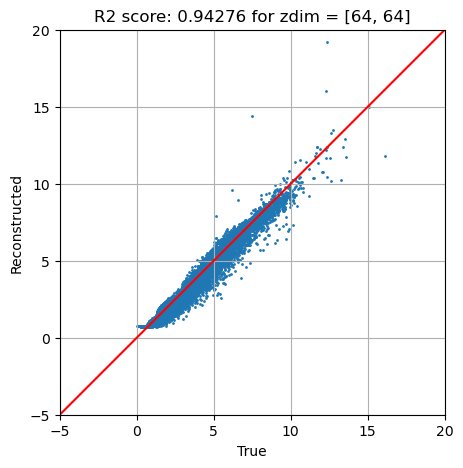

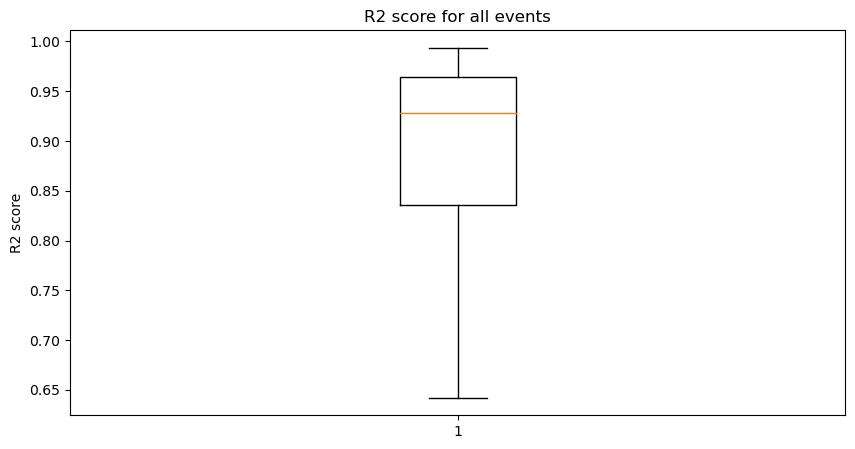

In [101]:
onshore_model = torch.load(f"{MLDir}/model/{reg}/out/model_onshore_ch_{channels_on}_minepoch_{train_size}.pt", map_location=torch.device('cpu'))
# Test model for final evaluation
#read model from file for testing
model = onshore_model
model.eval()
summary(model,(nflood_grids,))
criterion = nn.MSELoss()
print(red_d_array.shape)
test_dataset = torch.tensor(red_d_array, dtype=torch.float32).to('cpu')
print(test_dataset.shape)

with torch.no_grad():
    recon_data = model(test_dataset)
tloss = criterion(recon_data, test_dataset)
print(f"Test loss: {tloss :.5f}", end="\r")

recon_data = recon_data[:, :].cpu().detach().numpy()

# Flatten the tables along the n_gauge and n_time axes to get 2D arrays (neve, n_gauge * n_time)
flat_table1 = np.transpose(test_dataset)
flat_table2 = np.transpose(recon_data)

# Compute the R2 score for each event
r2_scores_on = r2_score(flat_table1, flat_table2, multioutput='raw_values')

#count events with score above 0.7
np.sum(r2_scores_on > 0.7)

# Plot results max height for all events
test_max = np.max(red_d_array,axis=(1))
recon_max = np.max(recon_data,axis=(1))

plt.figure(figsize=(5, 5))
plt.scatter(test_max, recon_max, s=1)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.title(f"R2 score: {r2_score(test_max, recon_max):.5f} for zdim = {channels_on}")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-5, 20)
plt.ylim(-5, 20)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

#plot r2 score as box plot
plt.figure(figsize=(10,5))
plt.boxplot(r2_scores_on,showfliers=False)
plt.title('R2 score for all events')
plt.ylabel('R2 score')
plt.show()

-0.012005912


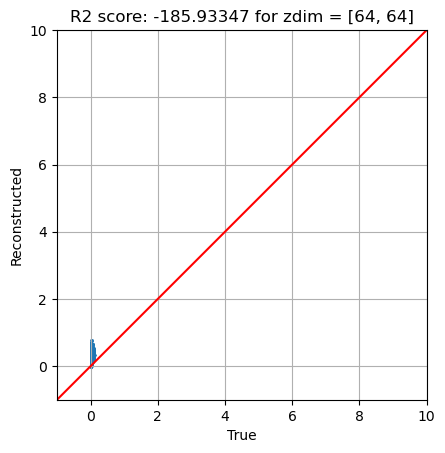

In [102]:
eve_no = 9
print(min(recon_data[eve_no,:]))

plt.scatter(test_dataset[eve_no,:], recon_data[eve_no,:], s=1)
plt.title(f"R2 score: {r2_score(test_dataset[eve_no,:], recon_data[eve_no,:]):.5f} for zdim = {channels_on}")
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

# print(min(flat_table2[:,eve_no]))
# plt.scatter(flat_table1[:,eve_no], flat_table2[:,eve_no], s=1)
# plt.title(f"R2 score: {r2_score(flat_table1[:,eve_no], flat_table2[:,eve_no]):.5f} for zdim = {channels_on}")
# plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.xlim(-1, 10)
# plt.ylim(-1, 10)
# plt.grid()
# plt.xlabel('True')
# plt.ylabel('Reconstructed')
# plt.show()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]       5,822,656
         LeakyReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
         LeakyReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 64]           4,160
         LeakyReLU-6                   [-1, 64]               0
            Linear-7                [-1, 90978]       5,913,570
         LeakyReLU-8                [-1, 90978]               0
Total params: 11,744,546
Trainable params: 11,744,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.35
Forward/backward pass size (MB): 1.39
Params size (MB): 44.80
Estimated Total Size (MB): 46.54
----------------------------------------------------------------
(10175, 90978)
torch.Size([10175, 

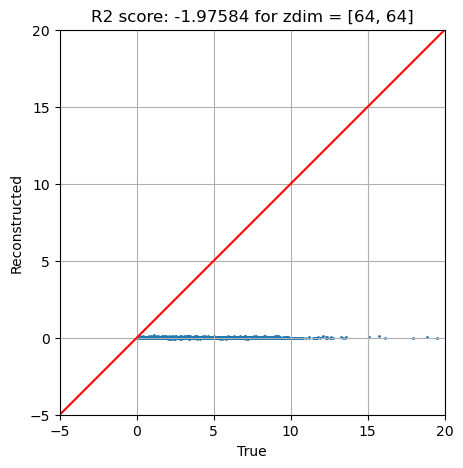

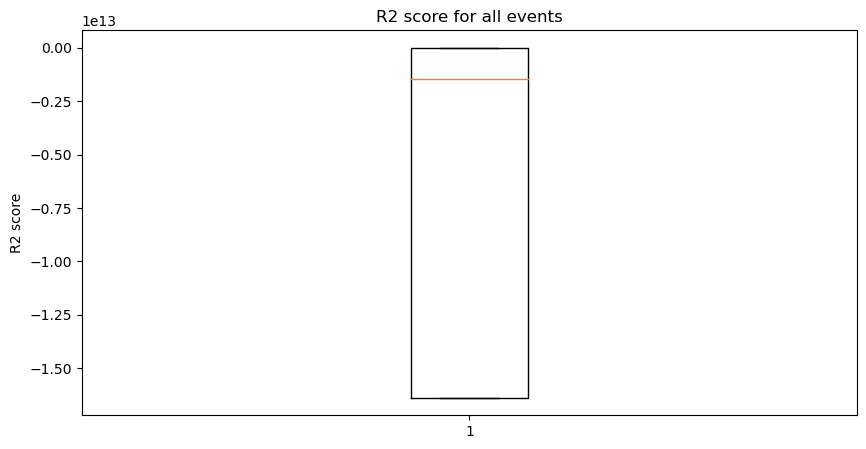

In [105]:
deform_model = torch.load(f"{MLDir}/model/{reg}/out/model_deform_ch_{channels_on}_minepoch_{train_size}.pt", map_location=torch.device('cpu'))# Test model for final evaluation
#read model from file for testing
model = deform_model
model.eval()
summary(model,(nflood_grids,))
criterion = nn.MSELoss()
print(red_dZ_array.shape)
test_dataset = torch.tensor(red_dZ_array, dtype=torch.float32).to('cpu')
print(test_dataset.shape)

with torch.no_grad():
    recon_data = model(test_dataset)
tloss = criterion(recon_data, test_dataset)
print(f"Test loss: {tloss :.5f}", end="\r")

recon_data = recon_data[:, :].cpu().detach().numpy()

# Flatten the tables along the n_gauge and n_time axes to get 2D arrays (neve, n_gauge * n_time)
flat_table1 = np.transpose(test_dataset)
flat_table2 = np.transpose(recon_data)

# Compute the R2 score for each event
r2_scores_on = r2_score(flat_table1, flat_table2, multioutput='raw_values')

#count events with score above 0.7
np.sum(r2_scores_on > 0.7)

# Plot results max height for all events
test_max = np.max(red_d_array,axis=(1))
recon_max = np.max(recon_data,axis=(1))

plt.figure(figsize=(5, 5))
plt.scatter(test_max, recon_max, s=1)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.title(f"R2 score: {r2_score(test_max, recon_max):.5f} for zdim = {channels_on}")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-5, 20)
plt.ylim(-5, 20)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

#plot r2 score as box plot
plt.figure(figsize=(10,5))
plt.boxplot(r2_scores_on,showfliers=False)
plt.title('R2 score for all events')
plt.ylabel('R2 score')
plt.show()

-0.001245539


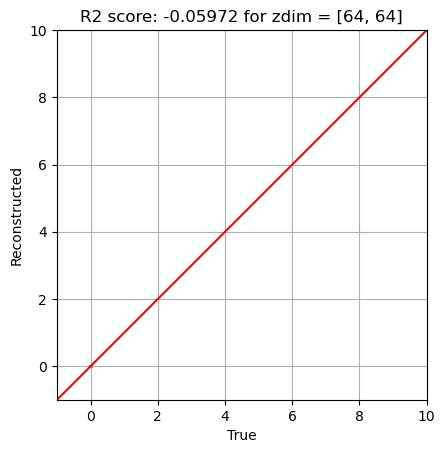

Run MLS-5 received abort signal. Exiting
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/naveenragur/ML4Sicily/e/MLS-5/metadata


: 

In [106]:
eve_no = 9
print(min(recon_data[eve_no,:]))

plt.scatter(test_dataset[eve_no,:], recon_data[eve_no,:], s=1)
plt.title(f"R2 score: {r2_score(test_dataset[eve_no,:], recon_data[eve_no,:]):.5f} for zdim = {channels_on}")
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

# print(min(flat_table2[:,eve_no]))
# plt.scatter(flat_table1[:,eve_no], flat_table2[:,eve_no], s=1)
# plt.title(f"R2 score: {r2_score(flat_table1[:,eve_no], flat_table2[:,eve_no]):.5f} for zdim = {channels_on}")
# plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.xlim(-1, 10)
# plt.ylim(-1, 10)
# plt.grid()
# plt.xlabel('True')
# plt.ylabel('Reconstructed')
# plt.show()


In [33]:
def calc_scores(true,pred,locindices,threshold=0.2):
    #only test where there is significant flooding
    true[true<threshold] = 0
    predic[predic<threshold] = 0
    mse_val = mean_squared_error(true,pred)
    r2_val = r2_score(true,pred)
    pt_er = true[locindices] - pred[locindices]

    # sel = true>=threshold
    # true = true[sel]
    # pred = pred[sel]
    # #to avoid division by zero    
    # pred[pred==0]=1e-10
    # #calculate Aidan's no K and k small 
    # ratio = true/pred
    # logval = np.log(ratio)
    # logval_sq = logval**2

    # logk = logval.mean()

    # logksmall = ((logval_sq.mean()) - (logk**2))**0.5
    # KCap = np.exp(logk)
    # Ksmall = np.exp(logksmall)

    return mse_val,r2_val,true[locindices],pred[locindices],pt_er #,KCap,Ksmall


In [10]:
control_points =  [[37.5022,15.0960],
          [37.48876,15.08936],
          [37.47193,15.07816],
          [37.46273,15.08527],
          [37.46252,15.08587],
          [37.45312,15.07874],
          [37.42821,15.08506],
          [37.40958,15.08075],
          [37.38595,15.08539],
          [37.35084,15.08575],
          [37.33049,15.07029],
          [37.40675,15.05037]
          ]

        #points to evaluate
# (2130, 653, 416589)
# (1980, 595, 406966)
# (1794, 496, 382850)
# (1691, 559, 366654)
# (1689, 564, 366384)
# (1585, 501, 348891)
# (1308, 557, 300485)
# (1101, 519, 261213)
# (839, 560, 196458)
# (450, 563, 127165)
# (224, 427, 61790)
# (1070, 252, 252416)

In [11]:
all_ids = np.loadtxt('../data/events/shuffled_events_CT.txt', ,skiprows=0)
test_ids = all_ids[int(len(all_ids)*0.65):]
eve_info = pd.read_csv('../data/info/about_alleve1212_PS.txt', sep='\t')
locindices = [416589,406966,382850,366654,366384,348891,300485,261213,196458,127165,61790,252416] #control points

#check performance per event
eve_perf = []
true_list = []
pred_list = []
er_list = []

#mse_val,r2_val,pt_er,KCap,Ksmall,truecount,predcount
for eve_no,eve in enumerate(test_ids):
    scores = calc_scores(test_data_out[eve_no,:], predic[eve_no,:],locindices,threshold=0.1)
    eve_perf.append([scores[0],scores[1],#scores[3],scores[4], #mse,r2,KCap,Ksmall
                     np.count_nonzero(test_data_out[eve_no,:]), #true count
                     np.count_nonzero(predic[eve_no,:])]) #pred count
    true_list.append(scores[2])
    pred_list.append(scores[3])
    er_list.append(scores[4])

#count of events less than 
eve_perf = np.array(eve_perf)
true_list = np.array(true_list)
pred_list = np.array(pred_list)
er_list = np.array(er_list)

#combine columns of true,pred,er into 12 column array
true_pred_er = np.column_stack((true_list,pred_list,er_list))


In [12]:
#save to file
np.savetxt(f"./../model/CT/out/er_onshore_pretrained_epoch_{num_epochs}.csv",eve_perf,fmt='%.5f',delimiter=',')


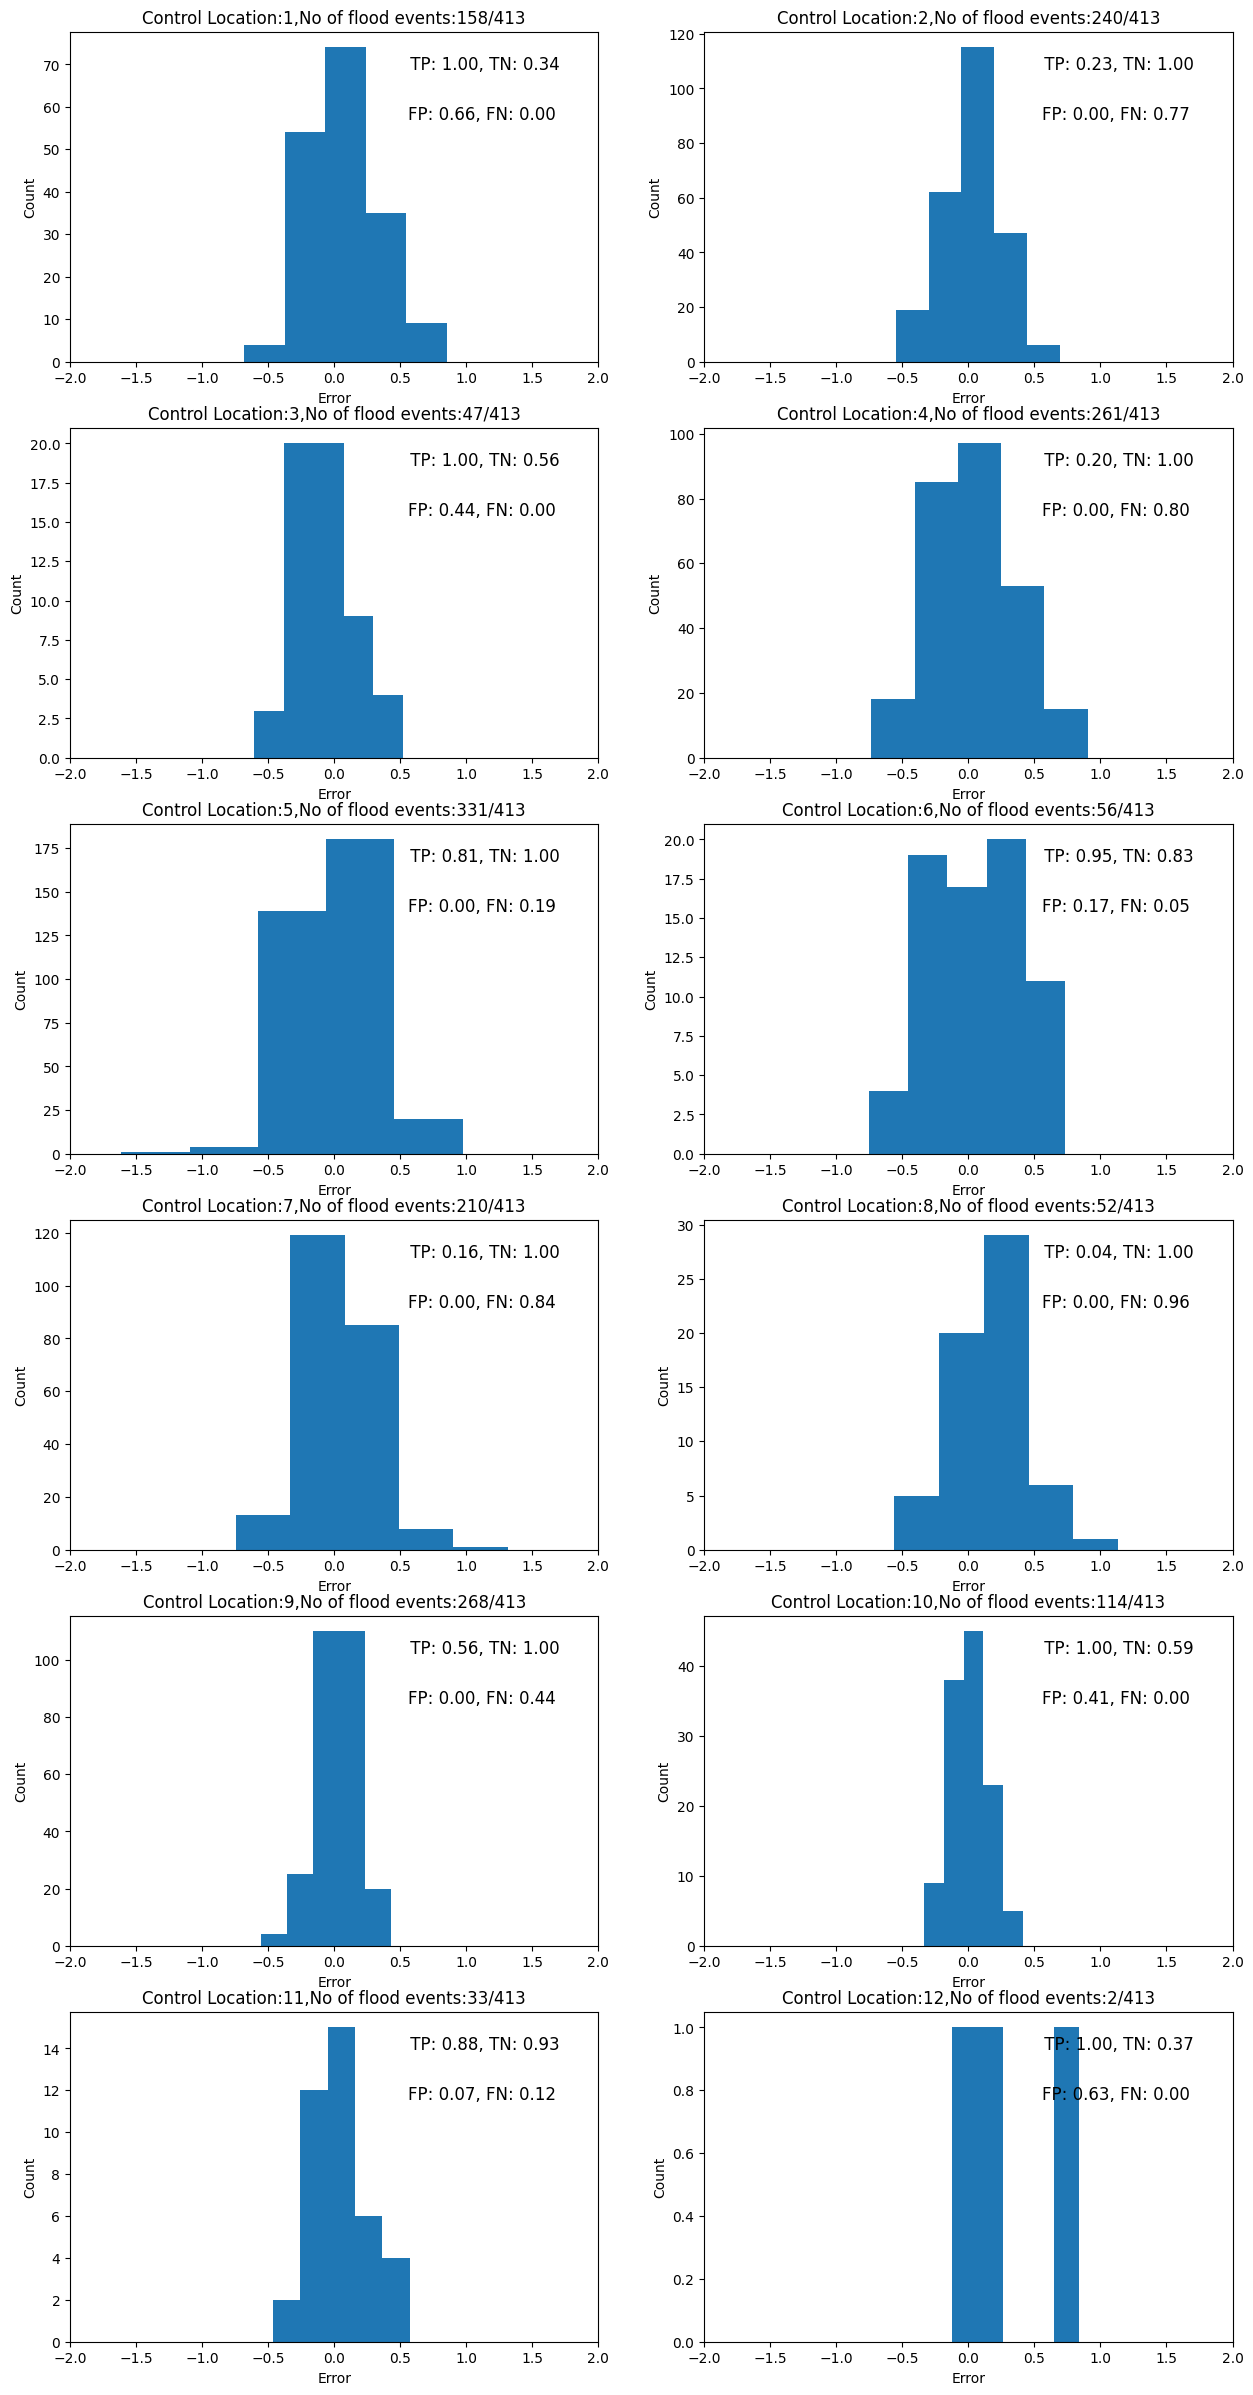

In [13]:
#plot the errors for the 4 locations as subplot from all events as histogram
plt.figure(figsize=(15, 30))
for i in range(12):
    plt.subplot(6,2,i+1)
    plt.hist(er_list[er_list[:,i]!=0,i],bins=5)
    #set x axis to be the same for all subplots
    plt.xlim(-2,2)
    #calculate hit and mis for each location based on depth of true and prediction
    #events crossing the threshold of 0.2 are considered flooded
    neve = np.count_nonzero(true_pred_er[:,i]>0.1)
    threshold = 0.1
    #true positive: true>0.2 and pred>0.2
    TP = np.count_nonzero((true_pred_er[:,i]>threshold) & (true_pred_er[:,i+4]>threshold))/(neve)
    TN = np.count_nonzero((true_pred_er[:,i]<threshold) & (true_pred_er[:,i+4]<threshold))/(len(true_pred_er[:,i])-neve)
    FP = np.count_nonzero((true_pred_er[:,i]<threshold) & (true_pred_er[:,i+4]>threshold))/(len(true_pred_er[:,i])-neve)
    FN = np.count_nonzero((true_pred_er[:,i]>threshold) & (true_pred_er[:,i+4]<threshold))/(neve)
    plt.title(f"Control Location:{i+1},No of flood events:{neve}/413")
    plt.text(0.78, 0.9, f" TP: {TP:.2f}, TN: {TN:.2f}", horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes,fontsize=12)
    plt.text(0.78, 0.75, f"FP: {FP:.2f}, FN: {FN:.2f}", horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes,fontsize=12)
    plt.xlabel('Error')
    plt.ylabel('Count')
    # plt.grid()
# plt.suptitle(f"Error distribution for 4 control locations for {len(eve_perf)} test events")

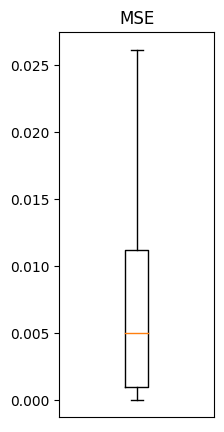

([], [])

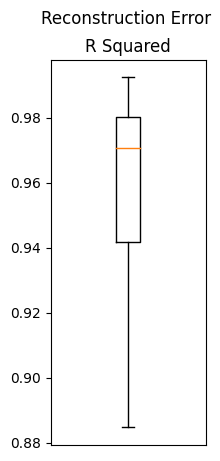

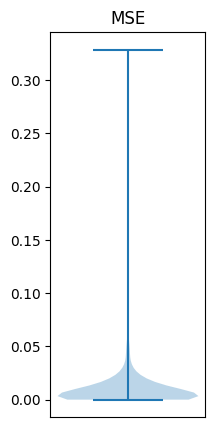

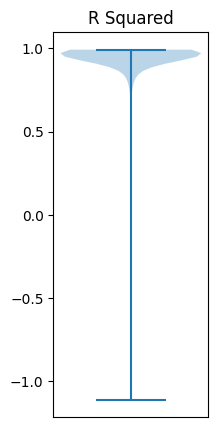

In [14]:
#plot the mse and r2 for all the events as box plot
plt.figure(figsize=(2, 5))
plt.boxplot(eve_perf[:,0],showfliers=False)
plt.title('MSE')
plt.xticks([])

plt.show()
plt.figure(figsize=(2, 5))
plt.boxplot(eve_perf[:,1],showfliers=False)
plt.title('R Squared')
plt.xticks([])

plt.suptitle(f"Reconstruction Error") # {len(eve_perf)} test events


# #make violin plot of the errors
# plt.figure(figsize=(15, 10))
# for i in range(4):
#     plt.subplot(2,2,i+1)
#     plt.violinplot(er_list[er_list[:,i]!=0,i],showmeans=True)
#     plt.xlim(-1,1)
#     plt.title(f"Control Location:{i+1}")
#     plt.xlabel('Error')
#     plt.ylabel('Count')
#     # plt.grid()


#make violin plot of the errors MSE and R2
plt.figure(figsize=(2, 5))
plt.violinplot(eve_perf[:,0],showmeans=False)
plt.title('MSE')
plt.xticks([])
plt.figure(figsize=(2, 5))
plt.violinplot(eve_perf[:,1],showmeans=False)
plt.title('R Squared')
plt.xticks([])
# plt.suptitle(f"Reconstruction Error") # {len(eve_perf)} test events



E01517N3917E01678N3772-PS-Mur_PNo_Hom-M792_E01654N3866_S000
E02113N3823E02873N3483-PS-Mur_PYes_Var-M792_E02227N3683_S000
E01548N3896E01854N3659-PS-Mur_PYes_Hom-M707_E01601N3726_S000
E02020N3739E02658N3366-PS-Str_PYes_Var-M902_E02188N3566_S003
E02113N3823E02873N3483-PS-Str_PYes_Hom-M792_E02259N3628_S000
E01548N3896E01854N3659-PS-Str_PYes_Var-M861_E01734N3775_S001
E01964N3926E02184N3685-PS-Str_PNo_Var-M754_E02088N3719_S000



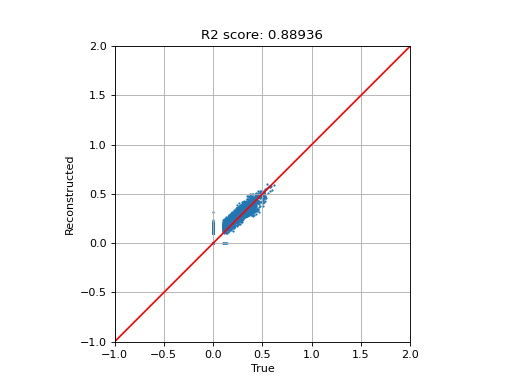
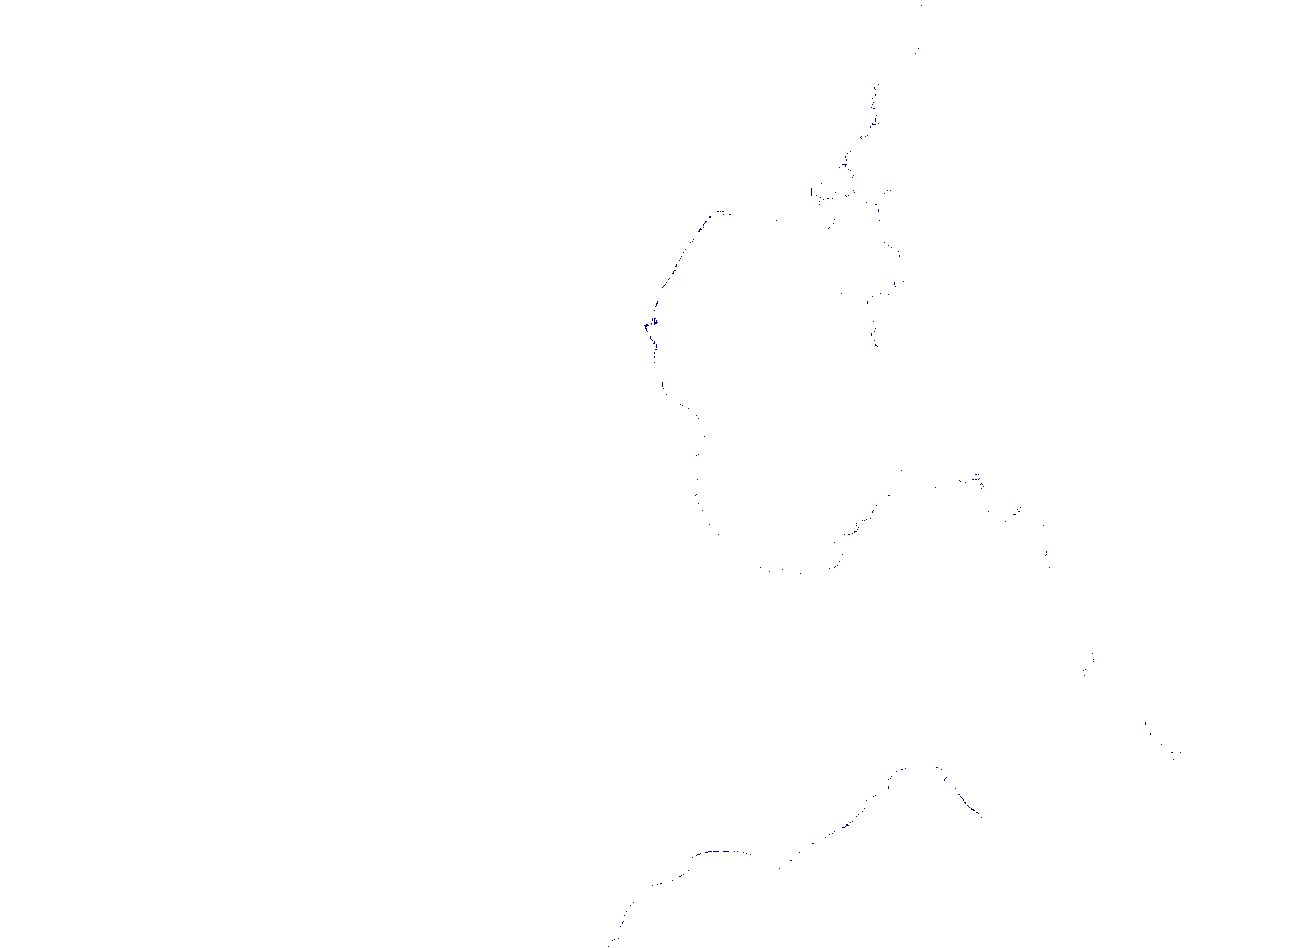
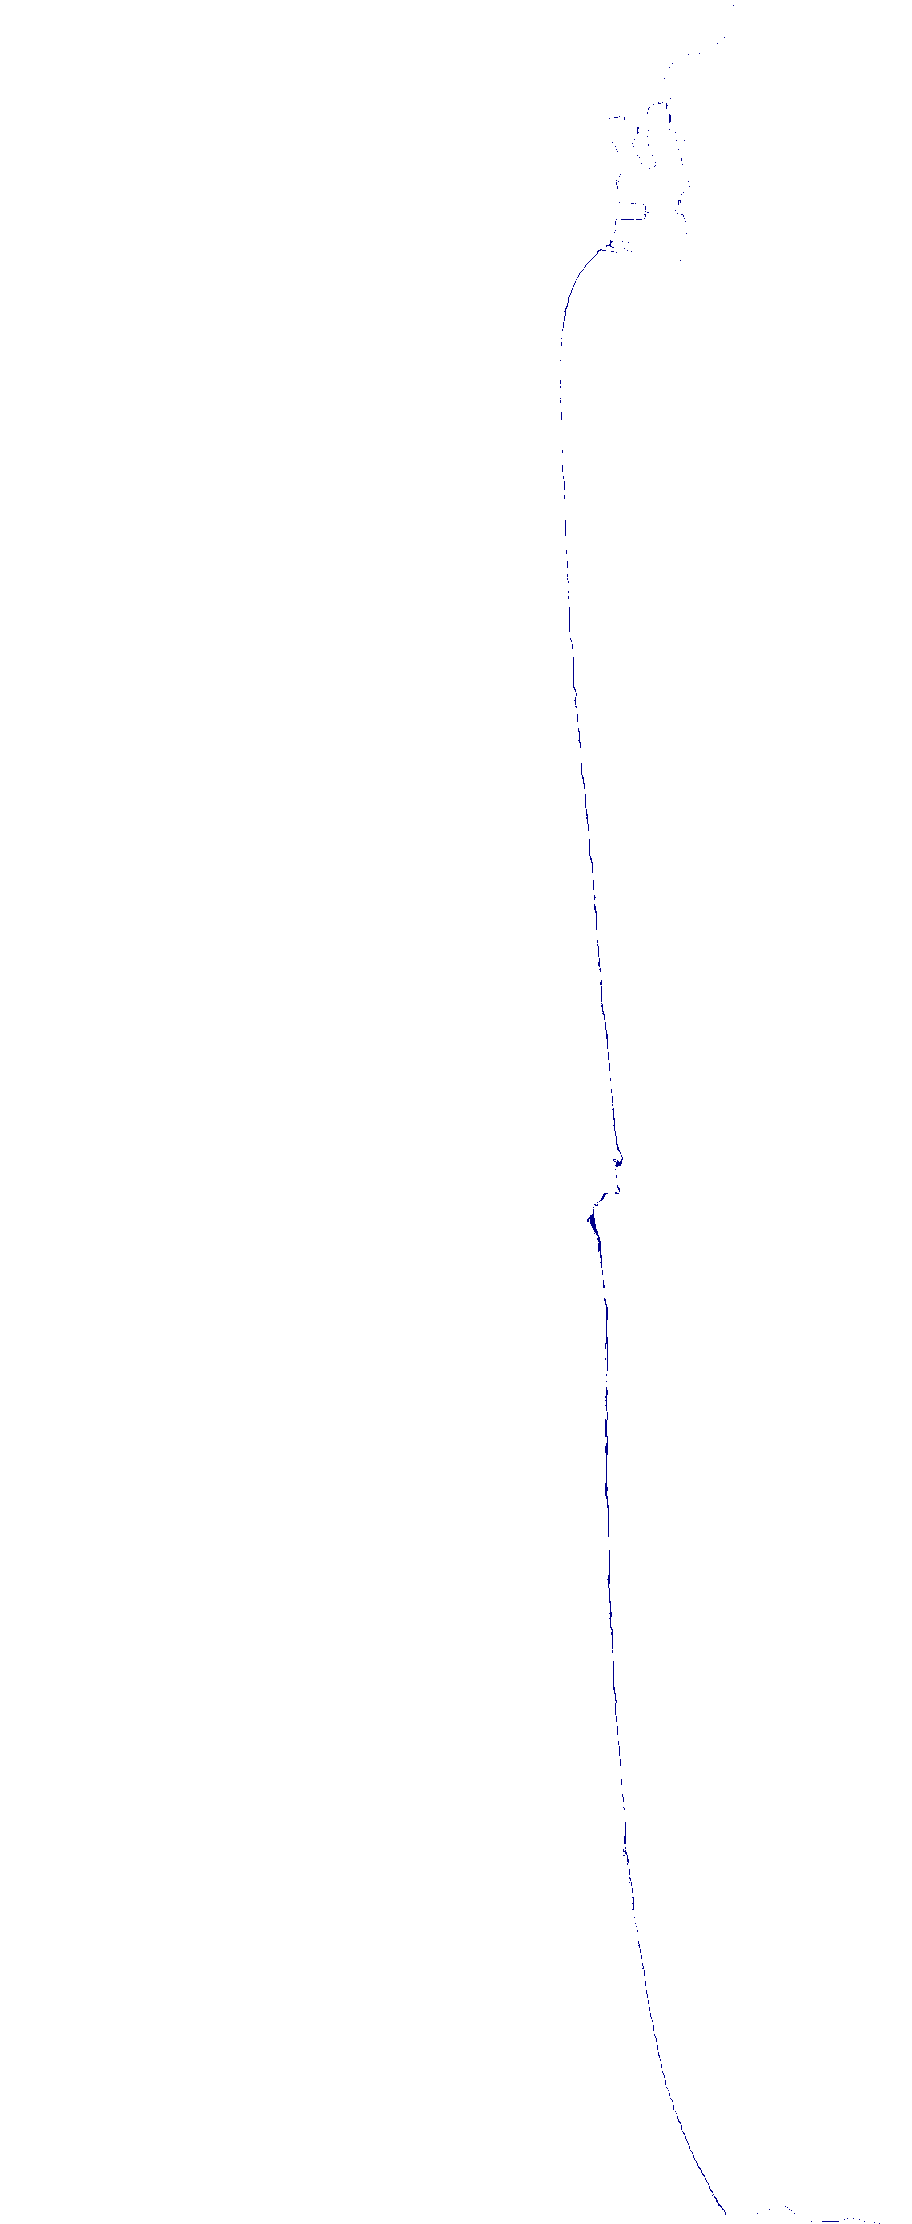
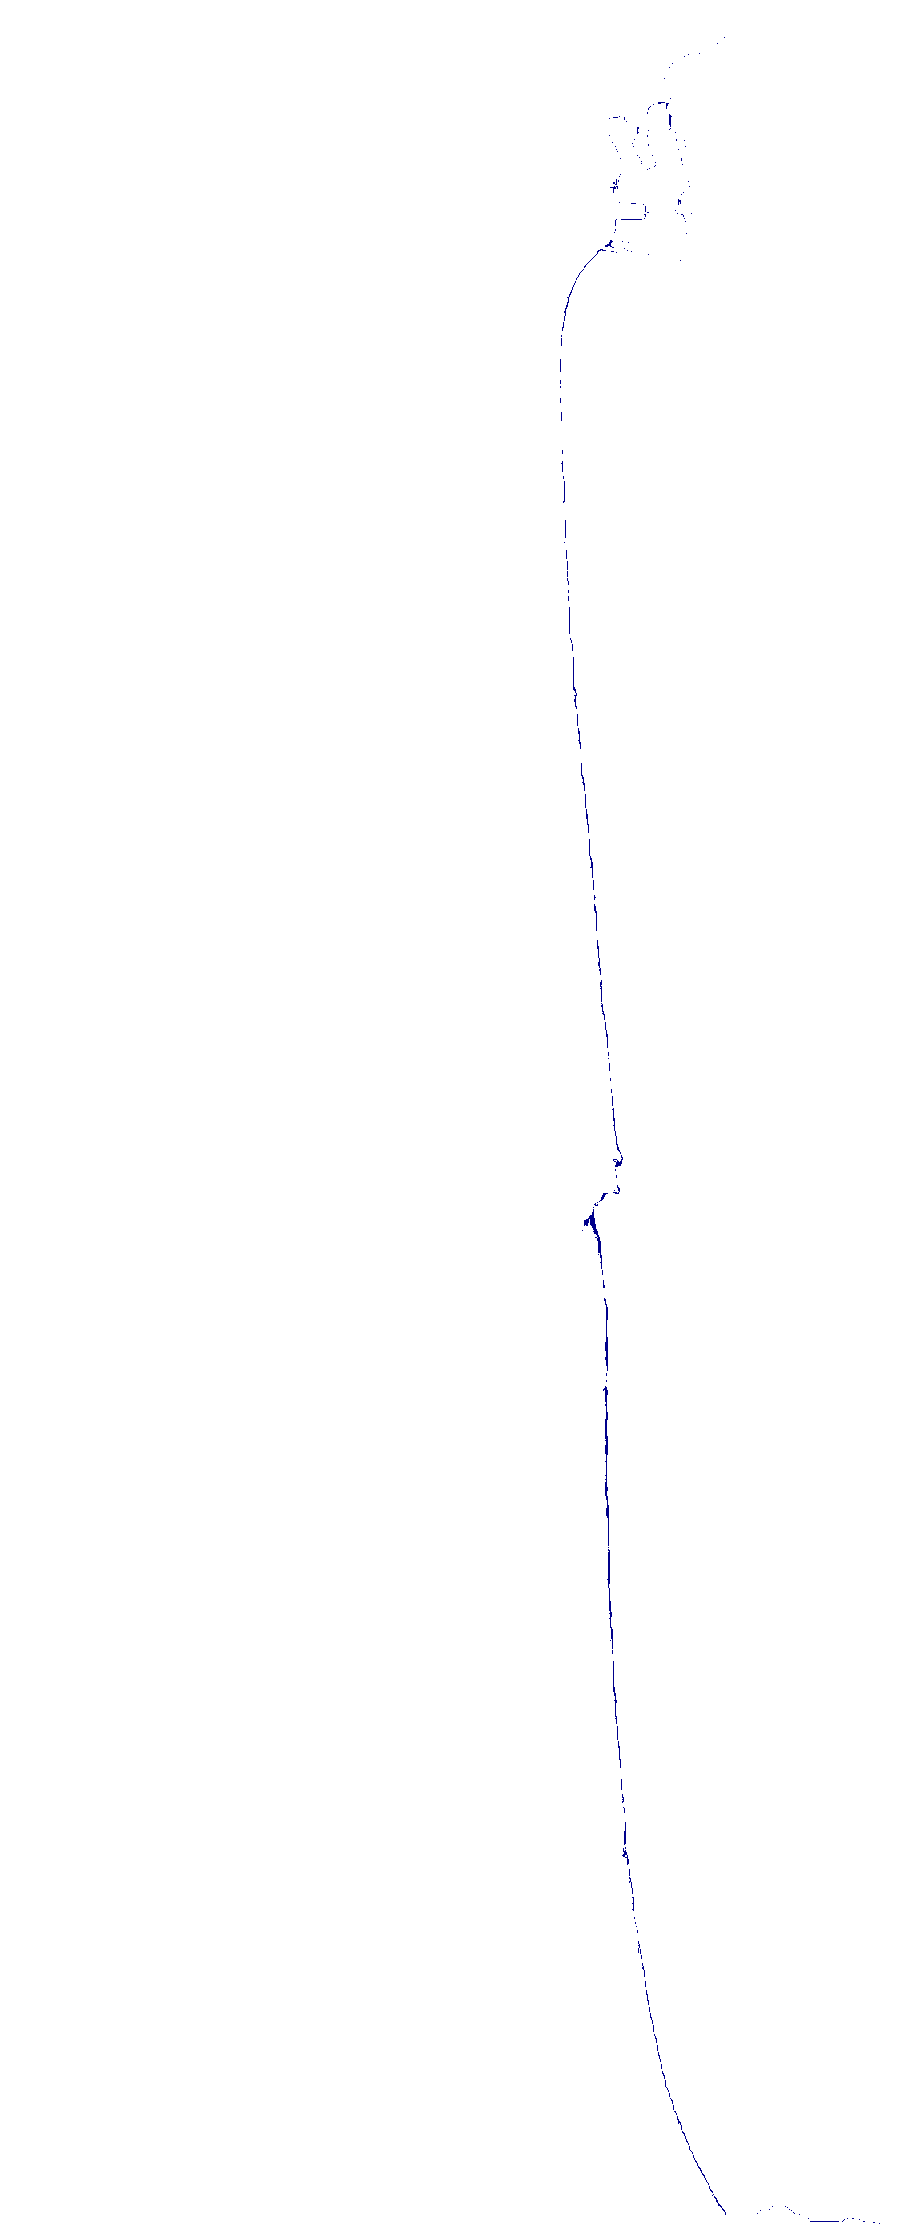
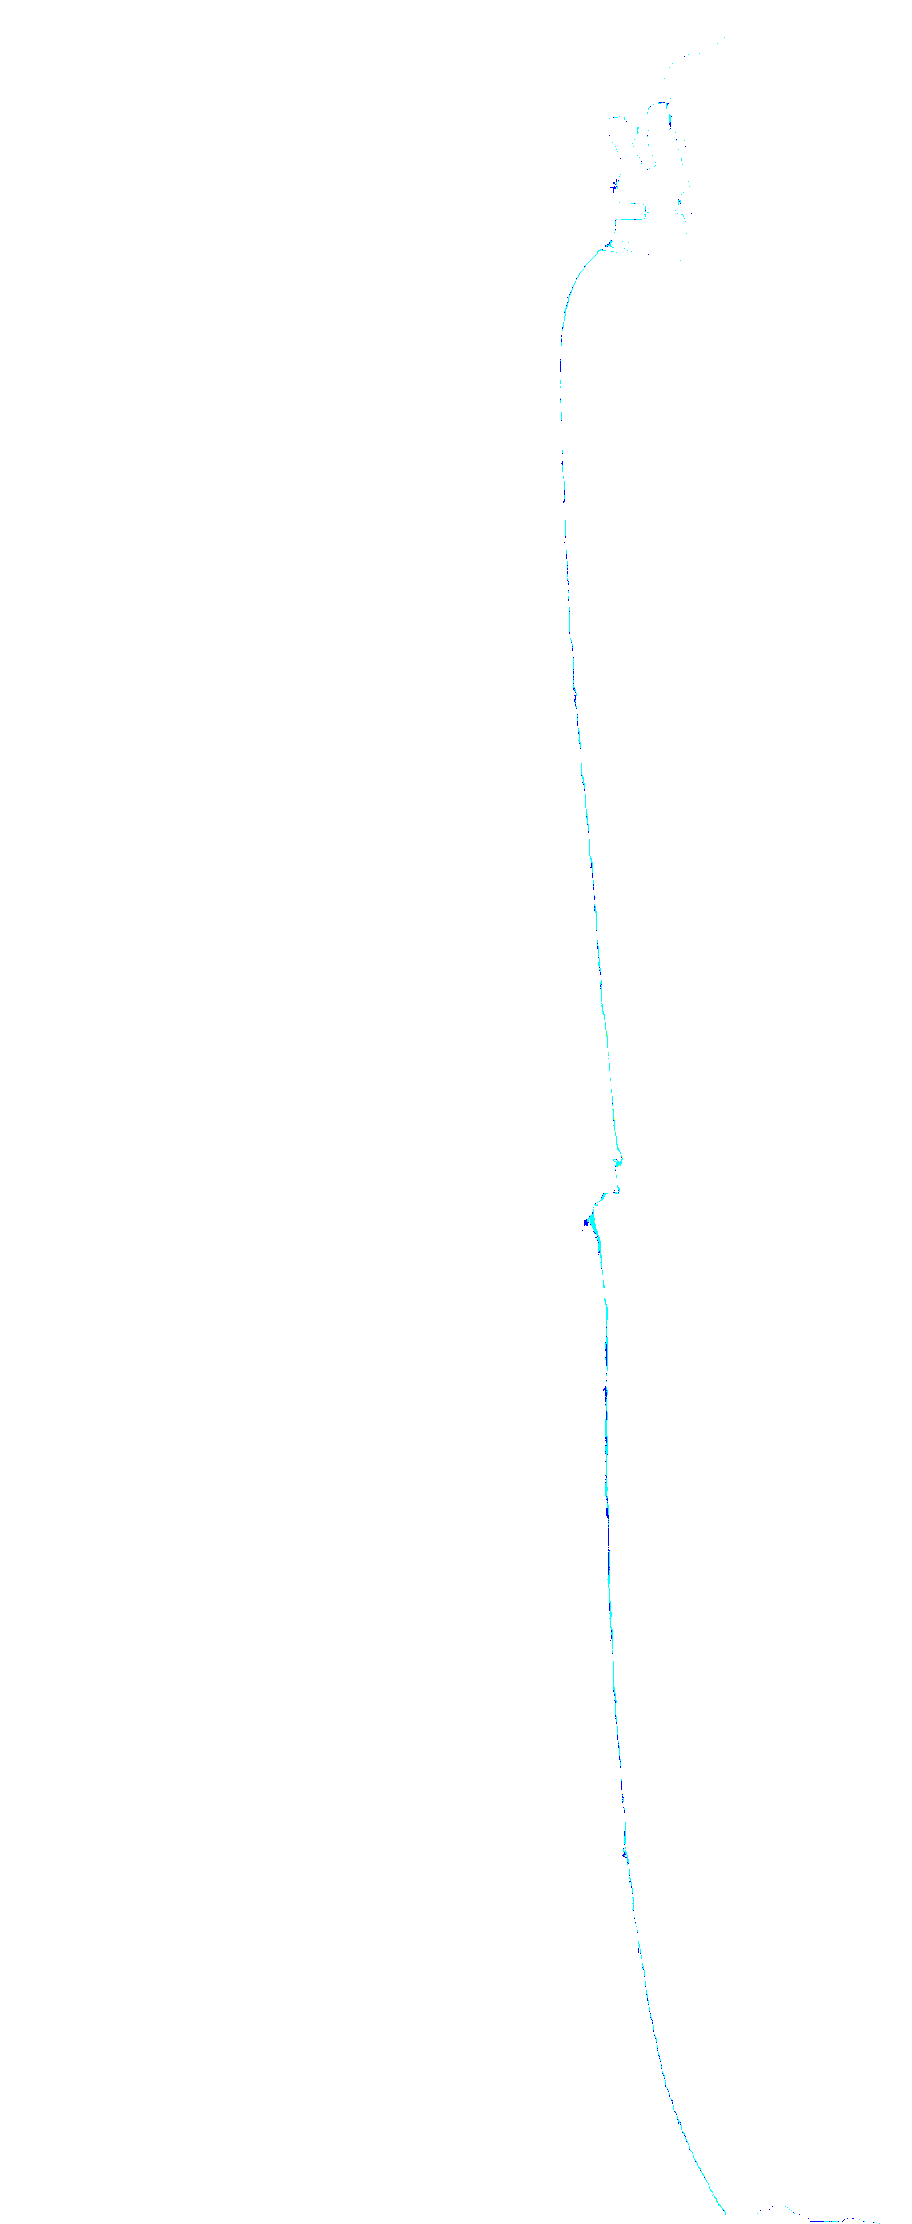

In [19]:
import base64
eventlist = 176,93,139,267,357,242,169
for eve_no in eventlist:
        eve = test_ids[eve_no]
        # Plot results max depth and error for one event with basemap around sicily

        #grid map
        error2fill = np.zeros(d_array.shape[1:])
        depth2fill = np.zeros(d_array.shape[1:])

        zero_mask = np.load('../data/processed/CT_zero_mask.npy')
        error2fill[~zero_mask] = test_data_out[eve_no, :] - predic[eve_no, :]
        depth2fill[~zero_mask] = predic[eve_no,:]

        true = test_data_out[eve_no,:]
        pred = predic[eve_no,:]
        true[true<threshold] = 0
        pred[pred<threshold] = 0

        plt.scatter(true, pred, s=1)
        plt.title(f"R2 score: {eve_perf[eve_no,1]:.5f}")
        plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim(pred.min().round(0)-1, true.max().round(0)+1)
        plt.ylim(pred.min().round(0)-1, true.max().round(0)+1)
        plt.grid()
        plt.xlabel('True')
        plt.ylabel('Reconstructed')
        #save to file
        image_path = './../resources/gis/true_pred.png'
        plt.savefig(image_path,dpi=80)
        plt.close()
        # plt.show()

        sim_dir = '../data/simu/PS_manning003/'
        # Load the points file
        data_pts = np.loadtxt('../resources/raw/pois_eastern_sicily_2km.txt', dtype=str)
        id_pts = data_pts[:, 0]
        lon_pts = data_pts[:, 1].astype(float)
        lat_pts = data_pts[:, 2].astype(float)
        z_pts = data_pts[:, 3].astype(float)

        ds_ts = xr.open_dataset(os.path.join(sim_dir,eve,'grid0_ts.nc')) #gridts file
        ds_grids_CT = xr.open_dataset(os.path.join(sim_dir,eve,'CT_flowdepth.nc')) #gridts file
        ds_grids_SR = xr.open_dataset(os.path.join(sim_dir,eve,'SR_flowdepth.nc')) #gridts file

        # Create a Folium map centered on the data's extent
        # m = folium.Map(location=[np.mean(lat_pts),np.mean(lon_pts)], zoom_start=10)
        m = folium.Map(location=[37.39564 , 15.08389], zoom_start=13.5)
        # Basemaps
        folium.TileLayer(tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr = 'Esri',
                name = 'Esri Satellite',
                overlay = False,
                control = True,
                show = False).add_to(m)

        # Create a feature group for the offshore points 
        fg_pts = folium.FeatureGroup(name='Offshore Points Txt').add_to(m)
        fg_ptsNC = folium.FeatureGroup(name='Offshore Points NetCDF').add_to(m)
        fg_gridnc_SR = folium.FeatureGroup(name='SR Grid NetCDF').add_to(m)
        fg_gridnc_CT = folium.FeatureGroup(name='CT Grid NetCDF').add_to(m)
        fg_gridnc_ML_d = folium.FeatureGroup(name='ML Grid Depth NetCDF').add_to(m)
        fg_gridnc_ML_e = folium.FeatureGroup(name='ML Grid Error NetCDF').add_to(m)
        fg_conpts_CT = folium.FeatureGroup(name='CT Control Points').add_to(m)

        with open(image_path, 'rb') as lf:
                # open in binary mode, read bytes, encode, decode obtained bytes as utf-8 string
                b64_content = base64.b64encode(lf.read()).decode('utf-8')

        folium.plugins.FloatImage('data:image/png;base64,{}'.format(b64_content), bottom=2, left=2).add_to(m)


        #add eq lat lon point
        print(eve)

        # E01548N3896E01854N3659-PS-Str_PYes_Hom-M861_E01673N3781_S005
        lon = float(str(eve).split('_')[-2][1:5])/10
        lat = float(str(eve).split('_')[-2][7:11])/100

        folium.CircleMarker(location=[lat,lon],radius = 15,color='red',fill_color = 'red').add_to(m)

        # Add a marker for each point with a tooltip showing its id
        for id, lat, lon,z in zip(id_pts, lat_pts, lon_pts, z_pts):
                info = f"ID:{id}, Depth: {z} "  # Create tooltip string
                folium.Marker(location=[lat, lon],
                                tooltip=info,
                                icon=folium.Icon(color='blue', icon='')).add_to(fg_pts)

        # Add a marker for each point with a tooltip showing its id
        for i,pt in enumerate(control_points):
                folium.Marker(location=[pt[0], pt[1]],
                popup=folium.Popup("Control Point " + '{:01d}'.format(i+1),
                                        show=True)).add_to(fg_conpts_CT)


        df_ts = pd.DataFrame({'lat':ds_ts.latitude.values.astype(float),
                        'lon':ds_ts.longitude.values.astype(float),
                        'z':ds_ts.deformed_bathy.values.astype(float)})

        for i,row in df_ts.iterrows():
                info = f"ID:{i}, Depth: {row['z']} "  # Create tooltip string
                folium.Marker(location=[row['lat'], row['lon']],
                                tooltip=info,
                                icon=folium.Icon(color='red', icon='')).add_to(fg_ptsNC)

        # Add grid netcdfs
        #COLORMAP
        cmap = matplotlib.colors.ListedColormap(['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red','#FFFFFF00'])
        norm_fun = matplotlib.colors.BoundaryNorm([0.1, 1, 2, 5 , 7.5, 10,99999], cmap.N)

        colorbar = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red'],
                                index=[0.1, 1, 2, 5 , 7.5, 10], vmin=0.1, vmax=10,
                                caption='Max flow depth[m]')

        colorbar.add_to(m) 

        #SIRACUSA 
        data2plot = ds_grids_SR#.isel(time=0)
        data = np.flipud(data2plot.z.values.astype(float))
        data[data < threshold ] = np.nan
        lon,lat = np.meshgrid(data2plot.lon.values.astype(float),
                        data2plot.lat.values.astype(float))

        ext = [[lat.min(),lon.min()],
                [lat.max(),lon.max()]]
        folium.raster_layers.ImageOverlay(cmap(norm_fun(data)),ext,opacity=0.5).add_to(fg_gridnc_SR)


        #CATANIA 
        data2plot = ds_grids_CT#.isel(time=0)
        data = np.flipud(data2plot.z.values.astype(float))
        data[data < threshold] = np.nan
        lon,lat = np.meshgrid(data2plot.lon.values.astype(float),
                        data2plot.lat.values.astype(float))

        ext = [[lat.min(),lon.min()],
                [lat.max(),lon.max()]]

        folium.raster_layers.ImageOverlay(cmap(norm_fun(data)),ext,opacity=0.75).add_to(fg_gridnc_CT)

        #plot recon depth and error
        error2fill = np.flipud(error2fill)
        depth2fill = np.flipud(depth2fill)
        error2fill[depth2fill < threshold] = np.nan
        depth2fill[depth2fill < threshold] = np.nan
        folium.raster_layers.ImageOverlay(cmap(norm_fun(depth2fill)),ext,opacity=0.75).add_to(fg_gridnc_ML_d)

        ecmap = matplotlib.colors.ListedColormap(['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red','#FFFFFF00'])
        error_fun = matplotlib.colors.BoundaryNorm([-2.5,-1,-0.1,0.1,1,2.5,99], ecmap.N)

        ecolorbar = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red'],
                                index=[-2.5,-1,0,1,2.5], vmin=-2.5, vmax=2.5,
                                caption='Error in Max flow depth[m]')
        ecolorbar.add_to(m)
      
        folium.raster_layers.ImageOverlay(cmap(error_fun(error2fill)),ext,opacity=0.75).add_to(fg_gridnc_ML_e)

        # Add a layer control to turn on/off the feature groups
        folium.LayerControl().add_to(m)
        folium.plugins.MousePosition().add_to(m)

        #save as html
        m.save(f'./../model/CT/plot/CTevent_example_{eve_no}.html')

m

In [30]:
# print(model)
summary(model,(9,480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 480]           1,792
         LeakyReLU-2              [-1, 64, 480]               0
         AvgPool1d-3              [-1, 64, 240]               0
            Conv1d-4             [-1, 128, 240]          24,704
         LeakyReLU-5             [-1, 128, 240]               0
         AvgPool1d-6             [-1, 128, 120]               0
            Conv1d-7             [-1, 256, 120]          98,560
         LeakyReLU-8             [-1, 256, 120]               0
         AvgPool1d-9              [-1, 256, 60]               0
          Dropout-10              [-1, 256, 60]               0
          Flatten-11                [-1, 15360]               0
           Linear-12                   [-1, 64]         983,104
           Linear-13                   [-1, 64]           4,160
        LeakyReLU-14                   

In [31]:
for param in model.offshore_encoder.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 9, 3]) False
torch.Size([64]) False
torch.Size([128, 64, 3]) False
torch.Size([128]) False
torch.Size([256, 128, 3]) False
torch.Size([256]) False
torch.Size([64, 15360]) True
torch.Size([64]) True


In [32]:
for param in model.onshore_decoder.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([418877, 64]) False
torch.Size([418877]) False


In [33]:
for param in model.connect.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([64, 64]) True
torch.Size([64]) True


In [34]:
for param in model.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 9, 3]) False
torch.Size([64]) False
torch.Size([128, 64, 3]) False
torch.Size([128]) False
torch.Size([256, 128, 3]) False
torch.Size([256]) False
torch.Size([64, 15360]) True
torch.Size([64]) True
torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([418877, 64]) False
torch.Size([418877]) False
